In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 这里假设你的数据是一个名为"data"的列表，包含了你提供的所有数据点
df = pd.read_excel('sales_summary.xlsx')

data = df.iloc[:, 4].tolist()

# 将数据转换为pandas的Series对象，设置日期索引（假设从某一天开始）
start_date = pd.to_datetime('2020-07-01')
date_index = pd.date_range(start=start_date, periods=len(data), freq='D')
time_series = pd.Series(data, index=date_index)
time_series.head()

2020-07-01    35.374
2020-07-02    32.199
2020-07-03    35.896
2020-07-04    57.067
2020-07-05    61.816
Freq: D, dtype: float64

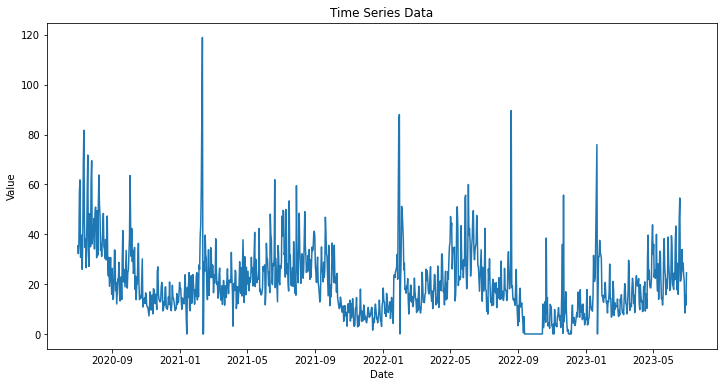

In [2]:
plt.figure(figsize=(12, 6))
plt.plot(time_series)
plt.title("Time Series Data")
plt.xlabel("Date")
plt.ylabel("Value")
plt.show()

In [3]:
# SARIMA模型的参数需要根据数据的性质来选择，这里使用了一些默认值，你可以根据需要进行调整
order = (1, 1, 1)  # ARIMA部分的阶数
seasonal_order = (0, 1, 1, 7)  # 季节性部分的阶数和季节周期（一天）

sarima_model = SARIMAX(time_series, order=order, seasonal_order=seasonal_order)
sarima_fit = sarima_model.fit(disp=False)

In [4]:
forecast_days = 7
forecast = sarima_fit.get_forecast(steps=forecast_days)

# 获取预测值和置信区间
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# 打印预测值
print(forecast_mean)

2023-07-01    28.229827
2023-07-02    28.050154
2023-07-03    21.405098
2023-07-04    19.229744
2023-07-05    19.345602
2023-07-06    19.498472
2023-07-07    23.145586
Freq: D, Name: predicted_mean, dtype: float64


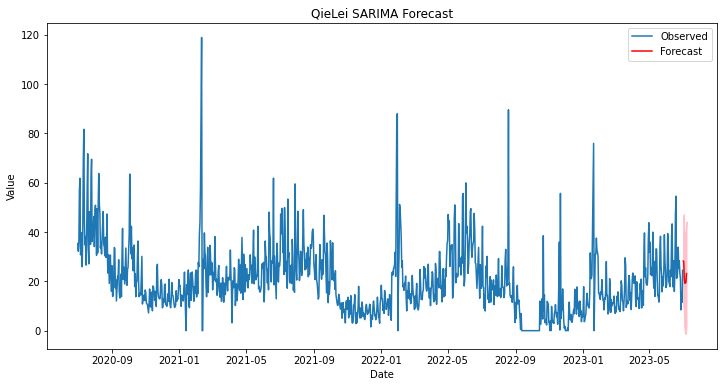

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(time_series, label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("QieLei SARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()

In [6]:
from itertools import product
import statsmodels.api as sm

# 定义一组候选参数
p = d = q = range(0, 2)
pdq = list(product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], s) for x in pdq for s in [7]]  # 假设季节性周期为7

best_aic = np.inf
best_params = None

# 通过循环来搜索最佳参数组合
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(time_series,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (param, param_seasonal)
        except:
            continue

# 输出最佳参数
print("Best AIC:", best_aic)
print("Best Parameters:", best_params)

Best AIC: 7822.514611086785
Best Parameters: ((1, 1, 1), (0, 1, 1, 7))
